# Race and Home Ownership

This is a deeper local analysis of some of the data from an [NJISJ report](https://njisj.org/reports/stateofinequity/) on Essex County
as reported in an [NJ Patch](https://patch.com/new-jersey/maplewood/s/iv2ag/essex-county-has-some-of-worst-racial-wealth-gaps-in-new-jersey-study?utm_source=local-update&utm_medium=email&utm_campaign=alert) article.

## Imports, Definitions, and Setup

In [1]:
import censusdis.data as ced

from censusdis.datasets import ACS5

from censusdis.states import NJ
from censusdis.counties.new_jersey import ESSEX, HUDSON

import pandas as pd
from matplotlib.ticker import FuncFormatter

In [2]:
# These are the groups that count households by tenure and race/ethicity.

TENURE_GROUP_ALL = "B25003"
TENURE_GROUP_WHITE = "B25003A"
TENURE_GROUP_BLACK = "B25003B"
TENURE_GROUP_HISPANIC_LATINO = "B25003I"

TENURE_GROUPS = {
    "Overall": TENURE_GROUP_ALL,
    "White": TENURE_GROUP_WHITE,
    "Black": TENURE_GROUP_BLACK,
    "Latina/o": TENURE_GROUP_HISPANIC_LATINO,
}

SUFFIX_TOTAL = "_001E"
SUFFIX_OWNER_OCCUPIED = "_002E"
SUFFIX_RENTER_OCCUPIED = "_003E"

VARIABLE_SUFFIXES = {
    "Total": SUFFIX_TOTAL,
    "Owner Occupied": SUFFIX_OWNER_OCCUPIED,
    "Renter Occupied": SUFFIX_RENTER_OCCUPIED,
}

In [3]:
ALL_VARIABLES_BY_GROUP = {
    group_name: {
        f"{group}{suffix}": f"{suffix_name}"
        for suffix_name, suffix in VARIABLE_SUFFIXES.items()
    }
    for group_name, group in TENURE_GROUPS.items()
}

ALL_VARIABLES_BY_GROUP

{'Overall': {'B25003_001E': 'Total',
  'B25003_002E': 'Owner Occupied',
  'B25003_003E': 'Renter Occupied'},
 'White': {'B25003A_001E': 'Total',
  'B25003A_002E': 'Owner Occupied',
  'B25003A_003E': 'Renter Occupied'},
 'Black': {'B25003B_001E': 'Total',
  'B25003B_002E': 'Owner Occupied',
  'B25003B_003E': 'Renter Occupied'},
 'Latina/o': {'B25003I_001E': 'Total',
  'B25003I_002E': 'Owner Occupied',
  'B25003I_003E': 'Renter Occupied'}}

In [4]:
ALL_VARIABLES_BY_GROUP_AND_TENURE = {
    group_name: {
        f"{suffix_name}": f"{group}{suffix}"
        for suffix_name, suffix in VARIABLE_SUFFIXES.items()
    }
    for group_name, group in TENURE_GROUPS.items()
}

ALL_VARIABLES_BY_GROUP_AND_TENURE

{'Overall': {'Total': 'B25003_001E',
  'Owner Occupied': 'B25003_002E',
  'Renter Occupied': 'B25003_003E'},
 'White': {'Total': 'B25003A_001E',
  'Owner Occupied': 'B25003A_002E',
  'Renter Occupied': 'B25003A_003E'},
 'Black': {'Total': 'B25003B_001E',
  'Owner Occupied': 'B25003B_002E',
  'Renter Occupied': 'B25003B_003E'},
 'Latina/o': {'Total': 'B25003I_001E',
  'Owner Occupied': 'B25003I_002E',
  'Renter Occupied': 'B25003I_003E'}}

In [5]:
ALL_VARIABLES = {
    f"{group_name} {suffix_name}": f"{group}{suffix}"
    for group_name, group in TENURE_GROUPS.items()
    for suffix_name, suffix in VARIABLE_SUFFIXES.items()
}

ALL_VARIABLES

{'Overall Total': 'B25003_001E',
 'Overall Owner Occupied': 'B25003_002E',
 'Overall Renter Occupied': 'B25003_003E',
 'White Total': 'B25003A_001E',
 'White Owner Occupied': 'B25003A_002E',
 'White Renter Occupied': 'B25003A_003E',
 'Black Total': 'B25003B_001E',
 'Black Owner Occupied': 'B25003B_002E',
 'Black Renter Occupied': 'B25003B_003E',
 'Latina/o Total': 'B25003I_001E',
 'Latina/o Owner Occupied': 'B25003I_002E',
 'Latina/o Renter Occupied': 'B25003I_003E'}

In [6]:
ALL_VARIABLE_NAMES = {v: k for k, v in ALL_VARIABLES.items()}

In [7]:
def add_ownership_rates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for group_name, group in TENURE_GROUPS.items():
        for suffix_name, suffix in VARIABLE_SUFFIXES.items():
            if suffix != SUFFIX_TOTAL:
                df[f"{group_name} {suffix_name} Fraction"] = (
                    df[f"{group}{suffix}"] / df[f"{group}{SUFFIX_TOTAL}"]
                )

    return df

## Download the Census Data

In [8]:
def data_for(group_name, **kwargs) -> pd.DataFrame:
    df = ced.download(
        dataset=ACS5,
        vintage=2022,
        download_variables=["NAME"] + list(ALL_VARIABLES_BY_GROUP[group_name].keys()),
        **kwargs
    )

    df.insert(len(kwargs) + 1, "GROUP", group_name)

    df.rename(ALL_VARIABLES_BY_GROUP[group_name], axis="columns", inplace=True)

    return df


def add_fractions(df: pd.DataFrame) -> pd.DataFrame:
    df["Owner Fraction"] = df["Owner Occupied"] / df["Total"]
    df["Renter Fraction"] = df["Renter Occupied"] / df["Total"]
    return df

In [9]:
df_county = pd.concat(
    [data_for(group_name, state=NJ, county=ESSEX) for group_name in TENURE_GROUPS]
).reset_index(drop=True)

df_county = add_fractions(df_county)

In [10]:
df_county

,STATE,COUNTY,NAME,GROUP,Total,Owner Occupied,Renter Occupied,Owner Fraction,Renter Fraction
0,34,013,"Essex County, New Jersey",Overall,312942,139811,173131,0.446763,0.553237
1,34,013,"Essex County, New Jersey",White,118641,74834,43807,0.630760,0.369240
2,34,013,"Essex County, New Jersey",Black,120863,34140,86723,0.282469,0.717531
3,34,013,"Essex County, New Jersey",Latina/o,64435,21891,42544,0.339738,0.660262


## Compare to NJISJ Numbers

The next three cells slice out numbers that correspond to those in Figure 3 of the [NJISJ Report](https://njisj.org/reports/stateofinequity/).
For Latino and Black households, the numbers match, but for white households they do not.

In [11]:
GROUP_ORDER = {"Latina/o": 0, "Black": 1, "White": 2}


def plot_hbar(df: pd.DataFrame, title: str, round100: bool = False):
    df_plot = df[df["GROUP"] != "Overall"][["GROUP", "Total", "Owner Occupied"]]

    df_plot["GROUP_ORDER"] = df_plot["GROUP"].map(GROUP_ORDER)
    df_plot = df_plot.sort_values(by="GROUP_ORDER", ascending=False)
    df_plot = df_plot.drop("GROUP_ORDER", axis="columns")

    ax = df_plot.plot.barh("GROUP")

    for container in ax.containers:
        if round100:
            ax.bar_label(
                container, fmt=lambda x: f"{100 * round(x / 100):,.0f}", padding=4
            )
        else:
            ax.bar_label(container, fmt=lambda x: f"{x:,.0f}", padding=4)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}"))
    ax.xaxis.grid()

    ax.set_ylabel("")
    ax.set_title(title)

    return ax

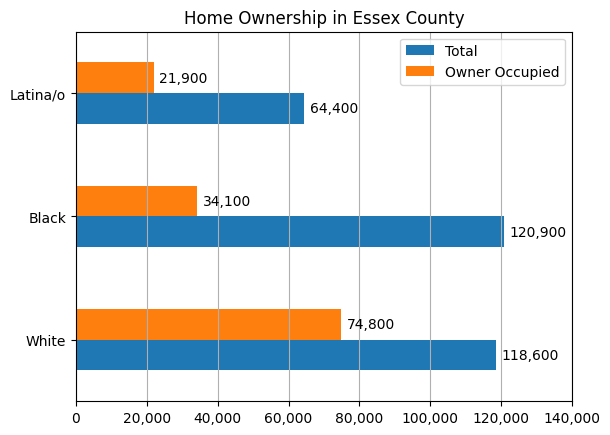

In [12]:
ax = plot_hbar(df_county, "Home Ownership in Essex County", round100=True)
_ = ax.set_xlim(0, 140_000)

## SoMa

In [13]:
df_soma_zips = pd.concat(
    [
        data_for(group_name, zip_code_tabulation_area=["07079", "07040"])
        for group_name in TENURE_GROUPS
    ]
).reset_index(drop=True)

df_soma_zips = add_fractions(df_soma_zips)

In [14]:
df_soma_zips.sort_values(by=["NAME", "GROUP"])

,ZIP_CODE_TABULATION_AREA,NAME,GROUP,Total,Owner Occupied,Renter Occupied,Owner Fraction,Renter Fraction
4,07040,ZCTA5 07040,Black,2507,1645,862,0.656163,0.343837
6,07040,ZCTA5 07040,Latina/o,367,261,106,0.711172,0.288828
0,07040,ZCTA5 07040,Overall,8401,6467,1934,0.769789,0.230211
2,07040,ZCTA5 07040,White,5152,4348,804,0.843944,0.156056
5,07079,ZCTA5 07079,Black,1283,835,448,0.650818,0.349182
7,07079,ZCTA5 07079,Latina/o,278,213,65,0.766187,0.233813
1,07079,ZCTA5 07079,Overall,5863,3842,2021,0.655296,0.344704
3,07079,ZCTA5 07079,White,3957,2649,1308,0.669447,0.330553


In [15]:
df_soma = (
    df_soma_zips.groupby("GROUP")[["Total", "Owner Occupied", "Renter Occupied"]]
    .sum()
    .reset_index()
)
df_soma["NAME"] = "SoMa"
df_soma = add_fractions(df_soma)

df_soma

,GROUP,Total,Owner Occupied,Renter Occupied,NAME,Owner Fraction,Renter Fraction
0,Black,3790,2480,1310,SoMa,0.654354,0.345646
1,Latina/o,645,474,171,SoMa,0.734884,0.265116
2,Overall,14264,10309,3955,SoMa,0.722729,0.277271
3,White,9109,6997,2112,SoMa,0.768141,0.231859


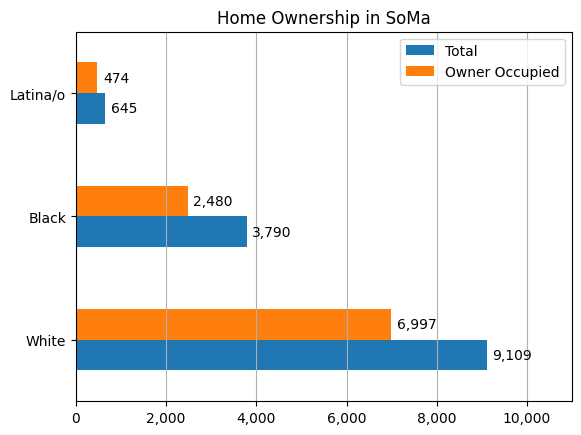

In [16]:
ax = plot_hbar(df_soma, "Home Ownership in SoMa")
_ = ax.set_xlim(0, 11_000)

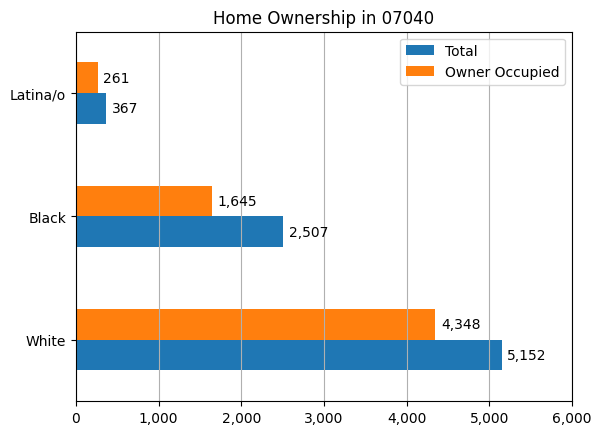

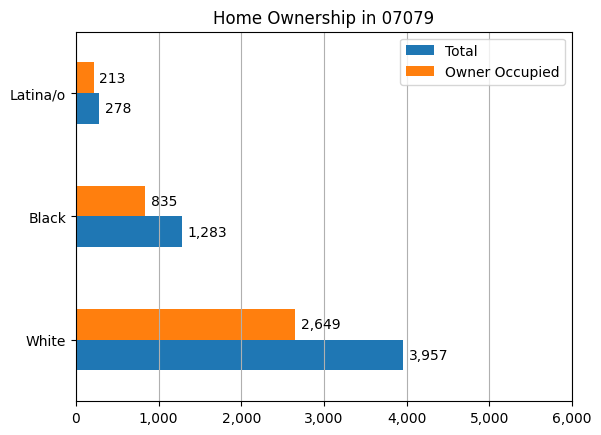

In [17]:
for zcta, df_zip in df_soma_zips.groupby("ZIP_CODE_TABULATION_AREA"):
    ax = plot_hbar(df_zip, f"Home Ownership in {zcta}")
    _ = ax.set_xlim(0, 6_000)

## Save to CSV

Put all the data into one csv.

In [18]:
df_csv = (
    pd.concat([df_county, df_soma_zips, df_soma])[
        [col for col in df_county.columns if col not in ["STATE", "COUNTY"]]
    ]
    .reset_index(drop=True)
    .rename(ALL_VARIABLE_NAMES, axis="columns")
)

df_csv.sort_values(by=["NAME", "GROUP"], inplace=True)

df_csv

,NAME,GROUP,Total,Owner Occupied,Renter Occupied,Owner Fraction,Renter Fraction
2,"Essex County, New Jersey",Black,120863,34140,86723,0.282469,0.717531
3,"Essex County, New Jersey",Latina/o,64435,21891,42544,0.339738,0.660262
0,"Essex County, New Jersey",Overall,312942,139811,173131,0.446763,0.553237
1,"Essex County, New Jersey",White,118641,74834,43807,0.630760,0.369240
12,SoMa,Black,3790,2480,1310,0.654354,0.345646
13,SoMa,Latina/o,645,474,171,0.734884,0.265116
14,SoMa,Overall,14264,10309,3955,0.722729,0.277271
15,SoMa,White,9109,6997,2112,0.768141,0.231859
8,ZCTA5 07040,Black,2507,1645,862,0.656163,0.343837
10,ZCTA5 07040,Latina/o,367,261,106,0.711172,0.288828


In [19]:
df_csv.to_csv("home_ownership.csv", index=False)